# 08. Pairing Cloud and non-Cloud Data

## Accessing and harmonizing data located within and outside of the NASA Earthdata Cloud

---

## Timing

- Exercise: 45 min


---

## Summary

This tutorial will combine several workflow steps and components from the previous days, demonstrating the process of using the geolocation of data available outside of the Earthdata Cloud to then access coincident variables of cloud-accessible data. This may be a common use case as NASA Earthdata continues to migrate to the cloud, producing a "hybrid" data archive across Amazon Web Services (AWS) and original on-premise data storage systems. Additionally, you may also want to combine field measurements with remote sensing data available on the Earthdata Cloud.

This specific example explores the pairing of the ICESat-2 [ATL07 Sea Ice Height](https://nsidc.org/data/atl07) data product, currently (as of November 2021) available publicly via direct download at the NSIDC DAAC, along with Sea Surface Temperature (SST) from the GHRSST MODIS L2 dataset ([MODIS_A-JPL-L2P-v2019.0](https://cmr.earthdata.nasa.gov/search/concepts/C1693233348-PODAAC.html)) available from PO.DAAC on the Earthdata Cloud. 

The use case we're looking at today centers over an area north of Greenland for a single day in June, where a melt pond was observed using the [NASA OpenAltimetry](https://openaltimetry.org/data/icesat2/?start_date=2019-06-22&annoId=180) application. Melt ponds are an important feature of Arctic sea ice dynamics, leading to an decrease in sea ice albedo and other changes in heat balance. Many NASA Earthdata datasets produce variables including sea ice albedo, sea surface temperature, air temperature, and sea ice height, which can be used to better understand these dynamics. 


### Objectives

1. Practice skills searching for data in CMR, determining granule coverage across two datasets over an area of interest.
2. Download data from an on-premise storage system to our cloud environment.
3. Read in 1-dimensional trajectory data (ICESat-2 ATL07) into `xarray` and perform attribute conversions.
4. Select and read in sea surface temperature (SST) data (MODIS_A-JPL-L2P-v2019.0) from the Earthdata Cloud into `xarray`.
5. Extract, resample, and plot coincident SST data based on ICESat-2 geolocation.

---

## Import packages

In [1]:
import os
from pathlib import Path
from pprint import pprint

# Access EDS
import requests

# Access AWS S3
import s3fs

# Read and work with datasets
import xarray as xr
import numpy as np
import h5py

# For plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import box

# For resampling
import pyresample

## Specify data, time range, and area of interest 

We are going to focus on getting data for an area north of Greenland for a single day in June.

These `bounding_box` and `temporal` variables will be used for data search, subset, and access below:

In [2]:
# Bounding Box spatial parameter in decimal degree 'W,S,E,N' format.
bounding_box = '-62.8,81.7,-56.4,83'

# Each date in yyyy-MM-ddTHH:mm:ssZ format; date range in start,end format
temporal = '2019-06-22T00:00:00Z,2019-06-22T23:59:59Z'

Since we've already demonstrated how to locate a dataset's `collection_id` and use the `cloud_hosted` parameter to determine whether a dataset resides in the Earthdata Cloud, we are going to skip forward and declare these variables:

In [3]:
modis_concept_id = 'C1940473819-POCLOUD'
icesat2_concept_id = 'C2003771980-NSIDC_ECS'

## Search and download ICESat-2 ATL07 files

Perform a granule search over our time and area of interest. How many granules are returned?

In [4]:
granule_url = 'https://cmr.earthdata.nasa.gov/search/granules'

In [5]:
response = requests.get(granule_url,
                       params={
                           'concept_id': icesat2_concept_id,
                           'temporal': temporal,
                           'bounding_box': bounding_box,
                           'page_size': 200,
                       },
                       headers={
                           'Accept': 'application/json'
                       }
                      )
print(response.headers['CMR-Hits'])

2


Print the file names, size, and links:



In [6]:
granules = response.json()['feed']['entry']
for granule in granules:
    print(f'{granule["producer_granule_id"]} {granule["granule_size"]} {granule["links"][0]["href"]}')

ATL07-01_20190622055317_12980301_004_01.h5 237.0905504227 https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL07.004/2019.06.22/ATL07-01_20190622055317_12980301_004_01.h5
ATL07-01_20190622200154_13070301_004_01.h5 230.9151573181 https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL07.004/2019.06.22/ATL07-01_20190622200154_13070301_004_01.h5


### Download ATL07 files

Although several services are supported for ICESat-2 data, we are demonstrating direct access through the “on-prem” file system at NSIDC for simplicity. 

Some of these services include: 
- [icepyx](https://icepyx.readthedocs.io/en/latest/) 
    - From the icepyx documentation: “icepyx is both a software library and a community composed of ICESat-2 data users, developers, and the scientific community. We are working together to develop a shared library of resources - including existing resources, new code, tutorials, and use-cases/examples - that simplify the process of querying, obtaining, analyzing, and manipulating ICESat-2 datasets to enable scientific discovery.” 
- [NSIDC DAAC Data Access and Service API](https://nsidc.org/support/how/how-do-i-programmatically-request-data-services#API) 
    - The API provided by the NSIDC DAAC allows you to access data programmatically using specific temporal and spatial filters. The same subsetting, reformatting, and reprojection services available on select data sets through NASA Earthdata Search can also be applied using this API. 
- [IceFlow](https://github.com/nsidc/NSIDC-Data-Tutorials/tree/main/notebooks/iceflow) 
    - The IceFlow python library simplifies accessing and combining data from several of NASA’s cryospheric altimetry missions, including ICESat/GLAS, Operation IceBridge, and ICESat-2. In particular, IceFlow harmonizes the various file formats and georeferencing parameters across several of the missions’ data sets, allowing you to analyze data across the multi-decadal time series.

We’ve found 2 granules. We’ll download the first one and write it to a file with the same name as the `producer_granule_id`.

We need the url for the granule as well. This is href links we printed out above.

In [7]:
icesat_id = granules[0]['producer_granule_id']
icesat_url = granules[0]['links'][0]['href']

To retrieve the granule data, we use the `requests.get()` method, which will utilize the .netrc file on the backend to authenticate the request against Earthdata Login.  

In [8]:
r = requests.get(icesat_url)

The response returned by requests has the same structure as all the other responses: a header and contents.  The header information has information about the response, including the size of the data we downloaded in bytes. 

In [9]:
for k, v in r.headers.items():
    print(f'{k}: {v}')

Date: Thu, 18 Nov 2021 04:02:03 GMT
Server: Apache
Vary: User-Agent
Content-Disposition: attachment
Content-Length: 248607461
Keep-Alive: timeout=15, max=100
Connection: Keep-Alive


The contents needs to be saved to a file.  To keep the directory clean, we will create a `downloads` directory to store the file.  We can use a shell command to do this or use the `makedirs` method from the `os` package. 

In [10]:
os.makedirs("downloads", exist_ok=True)

You should see a `downloads` directory in the file browser.

To write the data to a file, we use `open` to open a file.  We need to specify that the file is open for writing by using the _write-mode_ `w`.  We also need to specify that we want to write bytes by setting the _binary-mode_ `b`.  This is important because the response contents are bytes.  The default mode for `open` is `text-mode`. So make sure you use `b`.

We'll use the `with` statement _context-manager_ to open the file, write the contents of the response, and then close the file.  Once the data in `r.content` is written sucessfully to the file, or if there is an error, the file is closed by the _context-manager_.

We also need to prepend the `downloads` path to the filename.  We do this using `Path` from the `pathlib` package in the standard library.

In [11]:
outfile = Path('downloads', icesat_id)

In [12]:
if not outfile.exists():
    with open(outfile, 'wb') as f:
        f.write(r.content)

`ATL07-01_20190622055317_12980301_004_01.h5` is an HDF5 file.  `xarray` can open this but you need to tell it which group to read the data from.  In this case we read the sea ice segment height data for ground-track 1 left-beam. You can explore the variable hierarchy in [Earthdata Search](https://search.earthdata.nasa.gov/projects?p=C2003771980-NSIDC_ECS!C2003771980-NSIDC_ECS&pg[1][a]=2027648674!NSIDC_ECS&pg[1][v]=t&pg[1][id]=ATL07-01_20190622055317_12980301_004_01.h5&pg[1][gsk]=-start_date&pg[1][m]=esi0&q=atl07&tl=1637194666!3!!&m=13.8515625!-43.8046875!2!1!0!0%2C2), by selecting the Customize option under Download Data.

This code block performs the following operations: 
- Extracts the `height_segment_height` variable from the heights group, along with the dimension variables contained in the higher level `sea_ice_segments` group,
- Convert attributes from bytestrings to strings,
- Drops the HDF attribute DIMENSION_LIST,
- Sets _FillValue to NaN

In [13]:
variable_names = [
    '/gt1l/sea_ice_segments/latitude',
    '/gt1l/sea_ice_segments/longitude',
    '/gt1l/sea_ice_segments/delta_time',
    '/gt1l/sea_ice_segments/heights/height_segment_height'
    ]
with h5py.File(outfile, 'r') as h5:
    data_vars = {}
    for varname in variable_names:
        var = h5[varname]
        name = varname.split('/')[-1]
        # Convert attributes
        attrs = {}
        for k, v in var.attrs.items():
            if k != 'DIMENSION_LIST':
                if isinstance(v, bytes):
                    attrs[k] = v.decode('utf-8')
                else:
                    attrs[k] = v
        data = var[:]
        if '_FillValue' in attrs:
            data = np.where(data < attrs['_FillValue'], data, np.nan)
        data_vars[name] = (['segment'], data, attrs)
    is2_ds = xr.Dataset(data_vars)
    
is2_ds

<xarray.Dataset>
Dimensions:                (segment: 235584)
Dimensions without coordinates: segment
Data variables:
    latitude               (segment) float64 82.38 82.38 82.38 ... 72.61 72.61
    longitude              (segment) float64 -55.11 -55.11 ... 145.1 145.1
    delta_time             (segment) float64 4.642e+07 4.642e+07 ... 4.642e+07
    height_segment_height  (segment) float32 nan nan nan ... -0.4335 -0.4463

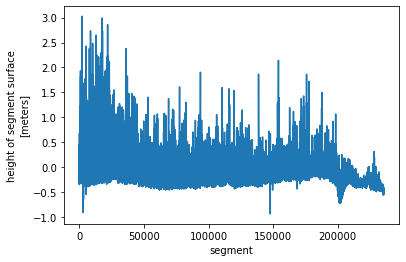

In [14]:
is2_ds.height_segment_height.plot() ;

## Determine the GHRSST MODIS L2 granules returned from our time and area of interest

In [15]:
response = requests.get(granule_url, 
                        params={
                            'concept_id': modis_concept_id,
                            'temporal': temporal,
                            'bounding_box': bounding_box,
                            'page_size': 200,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response.headers['CMR-Hits'])

14


In [16]:
granules = response.json()['feed']['entry']
for granule in granules:
    print(f'{granule["title"]} {granule["granule_size"]} {granule["links"][0]["href"]}')

20190622000501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0 20.71552562713623 s3://podaac-ops-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20190622000501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
20190622014501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0 9.34600830078125E-5 s3://podaac-ops-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20190622014501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
20190622032501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0 21.307741165161133 s3://podaac-ops-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20190622032501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
20190622050001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0 9.34600830078125E-5 s3://podaac-ops-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20190622050001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
20190622050501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0 20.065649032592773 s3://podaac-ops-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20190622050501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0

## Load data into xarray via S3 direct access

Our CMR granule search returned 14 files for our time and area of interest.  However, not all granules will be suitable for analysis.

I've identified the image with granule id G1956158784-POCLOUD as a good candidate, this is the 9th granule.  In this image, our area of interest is close to nadir.  This means that the instantaneous field of view over the area of interest cover a smaller area than at the edge of the image.

We are looking for the link for _direct download access via s3_.  This is a url but with a prefix `s3://`.  This happens to be the first href link in the metadata.  

For a single granule we can cut and paste the s3 link.  If we have several granules, the s3 links can be extracted with some simple code.

In [17]:
granule = granules[9]

for link in granule['links']:
    if link['href'].startswith('s3://'):
        s3_link = link['href']
        
s3_link

's3://podaac-ops-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20190622100001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc'

### Get S3 credentials
As with the previous S3 download tutorials we need credentials to access data from s3: access keys and tokens.

In [18]:
s3_credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()

Essentially, what we are doing in this step is to "mount" the s3 bucket as a file system.  This allows us to treat the S3 bucket in a similar way to a local file system.  

In [19]:
s3_fs = s3fs.S3FileSystem(
    key=s3_credentials["accessKeyId"],
    secret=s3_credentials["secretAccessKey"],
    token=s3_credentials["sessionToken"],
)

### Open a s3 file

Now we have the `S3FileSystem` set up, we can access the granule.  `xarray` cannot open a `S3File` directly, so we use the `open` method for the `S3FileSystem` to open the granule using the endpoint url we extracted from the metadata.  We also have to set the `mode='rb'`.  This opens the granule in read-only mode and in byte-mode.  Byte-mode is important.  By default, `open` opens a file as text - in this case it would just be a string of characters - and `xarray` doesn't know what to do with that.

We then pass the `S3File` object `f` to `xarray.open_dataset`.  For this dataset, we also have to set `decode_cf=False`.  This switch tells `xarray` not to use information contained in variable attributes to generate human readable coordinate variables.  Normally, this should work for netcdf files but for this particular cloud-hosted dataset, variable attribute data is not in the form expected by `xarray`.  We'll fix this.

In [20]:
f = s3_fs.open(s3_link, mode='rb')
modis_ds = xr.open_dataset(f, decode_cf=False)

If you click on the `Show/Hide Attributes` icon (the first document-like icon to the right of coordinate variable metadata) you can see that attributes are one-element arrays containing bytestrings.

In [21]:
modis_ds

<xarray.Dataset>
Dimensions:                  (nj: 2030, ni: 1354, time: 1)
Coordinates:
  * time                     (time) int32 1214042401
Dimensions without coordinates: nj, ni
Data variables:
    lat                      (nj, ni) float32 ...
    lon                      (nj, ni) float32 ...
    sea_surface_temperature  (time, nj, ni) int16 ...
    sst_dtime                (time, nj, ni) int16 ...
    quality_level            (time, nj, ni) int8 ...
    sses_bias                (time, nj, ni) int8 ...
    sses_standard_deviation  (time, nj, ni) int8 ...
    l2p_flags                (time, nj, ni) int16 ...
    chlorophyll_a            (time, nj, ni) float32 ...
    K_490                    (time, nj, ni) int16 ...
    wind_speed               (time, nj, ni) int8 ...
    dt_analysis              (time, nj, ni) int8 ...
Attributes: (12/49)
    Conventions:                [b'CF-1.7, ACDD-1.3']
    title:                      [b'MODIS Aqua L2P SST']
    summary:                    [b'Sea surface temperature retrievals produce...
    references:                 [b'GHRSST Data Processing Specification v2r5']
    institution:                [b'NASA/JPL/OBPG/RSMAS']
    history:                    [b'MODIS L2P created at JPL PO.DAAC']
    ...                         ...
    publisher_email:            [b'ghrsst-po@nceo.ac.uk']
    processing_level:           [b'L2P']
    cdm_data_type:              [b'swath']
    startDirection:             [b'Ascending']
    endDirection:               [b'Descending']
    day_night_flag:             [b'Day']

To fix this, we need to extract array elements as scalars, and convert those scalars from bytestrings to strings.  We use the `decode` method to do this.  The bytestrings are encoded as utf-8, which is a unicode character format.  This is the default encoding for `decode` but we've included it as an argument to be explicit.

Not all attributes are bytestrings.  Some are `floats`.  Take a look at `_FillValue`, and `valid_min` and `valid_max`.  To avoid an error, we use the `isinstance` function to check if the value of an attributes is type `bytes` - a bytestring.  If it is, then we decode it.  If not, we just extract the scalar and do nothing else.

We also fix the global attributes.

In [22]:
def fix_attributes(da):
    '''Decodes bytestring attributes to strings'''
    for attr, value in da.attrs.items():
        if isinstance(value[0], bytes):
            da.attrs[attr] = value[0].decode('utf-8')
        else:
            da.attrs[attr] = value[0]
    return

# Fix variable attributes
for var in modis_ds.variables:
    da = modis_ds[var]
    fix_attributes(da)
            
# Fix global attributes
fix_attributes(modis_ds)

With this done, we can use the `xarray` function `decode_cf` to convert the attributes. 

In [23]:
modis_ds = xr.decode_cf(modis_ds)

In [24]:
modis_ds

<xarray.Dataset>
Dimensions:                  (nj: 2030, ni: 1354, time: 1)
Coordinates:
    lat                      (nj, ni) float32 ...
    lon                      (nj, ni) float32 ...
  * time                     (time) datetime64[ns] 2019-06-22T10:00:01
Dimensions without coordinates: nj, ni
Data variables:
    sea_surface_temperature  (time, nj, ni) float32 ...
    sst_dtime                (time, nj, ni) timedelta64[ns] ...
    quality_level            (time, nj, ni) float32 ...
    sses_bias                (time, nj, ni) float32 ...
    sses_standard_deviation  (time, nj, ni) float32 ...
    l2p_flags                (time, nj, ni) int16 ...
    chlorophyll_a            (time, nj, ni) float32 ...
    K_490                    (time, nj, ni) float32 ...
    wind_speed               (time, nj, ni) float32 ...
    dt_analysis              (time, nj, ni) float32 ...
Attributes: (12/49)
    Conventions:                CF-1.7, ACDD-1.3
    title:                      MODIS Aqua L2P SST
    summary:                    Sea surface temperature retrievals produced a...
    references:                 GHRSST Data Processing Specification v2r5
    institution:                NASA/JPL/OBPG/RSMAS
    history:                    MODIS L2P created at JPL PO.DAAC
    ...                         ...
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L2P
    cdm_data_type:              swath
    startDirection:             Ascending
    endDirection:               Descending
    day_night_flag:             Day

Let's make a quick plot to take a look at the `sea_surface_temperature` variable.

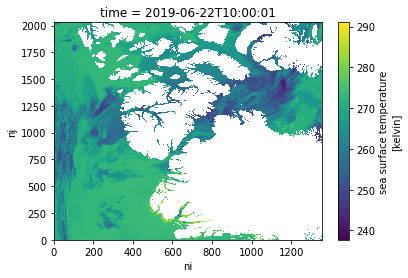

In [25]:
modis_ds.sea_surface_temperature.plot() ;

### Plot MODIS and ICESat-2 data on a map

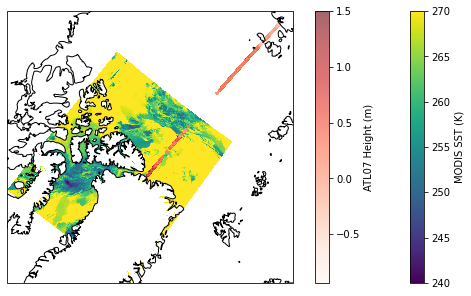

In [26]:
map_proj = ccrs.NorthPolarStereo()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection=map_proj)
ax.coastlines()

# Plot MODIS sst, save object as sst_img, so we can add colorbar
sst_img = ax.pcolormesh(modis_ds.lon, modis_ds.lat, modis_ds.sea_surface_temperature[0,:,:], 
                        vmin=240, vmax=270,  # Set max and min values for plotting
                        cmap='viridis', shading='auto',   # shading='auto' to avoid warning
                        transform=ccrs.PlateCarree())  # coords are lat,lon but map if NPS 

# Plot IS2 surface height 
is2_img = ax.scatter(is2_ds.longitude, is2_ds.latitude,
                     c=is2_ds.height_segment_height, 
                     vmax=1.5,  # Set max height to plot
                     cmap='Reds', alpha=0.6, s=2,
                     transform=ccrs.PlateCarree())

# Add colorbars
fig.colorbar(sst_img, label='MODIS SST (K)')
fig.colorbar(is2_img, label='ATL07 Height (m)')



### Extract SST coincident with ICESat-2 track
The MODIS SST is swath data, not a regularly-spaced grid of sea surface temperatures.  ICESat-2 sea surface heights are irregularly spaced segments along one ground-track traced by the ATLAS instrument on-board ICESat-2.  Fortunately, `pyresample` allows us to resample swath data.

`pyresample` has many resampling methods.  We're going to use the nearest neighbour resampling method, which is implemented using a k-dimensional tree algorithm or [K-d tree](https://en.wikipedia.org/wiki/K-d_tree#Nearest_neighbour_search).  K-d trees are data structures that improve search efficiency for large data sets.

The first step is to define the _geometry_ of the ICESat-2 and MODIS data.  To do this we use the latitudes and longitudes of the datasets.

In [27]:
is2_geometry = pyresample.SwathDefinition(lons=is2_ds.longitude,
                                          lats=is2_ds.latitude)

In [28]:
modis_geometry = pyresample.SwathDefinition(lons=modis_ds.lon, lats=modis_ds.lat)

We then implement the resampling method, passing the two geometries we have defined, the data array we want to resample - in this case sea surface temperature, and a search radius.  The resampling method expects a `numpy.Array` rather than an `xarray.DataArray`, so we use `values` to get the data as a `numpy.Array`.

We set the search radius to 1000 m.  The MODIS data is nominally 1km spacing.

In [29]:
search_radius=1000.
fill_value = np.nan
is2_sst = pyresample.kd_tree.resample_nearest(
    modis_geometry,
    modis_ds.sea_surface_temperature.values,
    is2_geometry,
    search_radius,
    fill_value=fill_value
)

In [30]:
is2_sst

array([263.375, 263.375, 263.375, ...,     nan,     nan,     nan],
      dtype=float32)

In [31]:
is2_ds['sea_surface_temperature'] = xr.DataArray(is2_sst, dims='segment')
is2_ds

<xarray.Dataset>
Dimensions:                  (segment: 235584)
Dimensions without coordinates: segment
Data variables:
    latitude                 (segment) float64 82.38 82.38 82.38 ... 72.61 72.61
    longitude                (segment) float64 -55.11 -55.11 ... 145.1 145.1
    delta_time               (segment) float64 4.642e+07 4.642e+07 ... 4.642e+07
    height_segment_height    (segment) float32 nan nan nan ... -0.4335 -0.4463
    sea_surface_temperature  (segment) float32 263.4 263.4 263.4 ... nan nan nan

### Plot SST and Height along track
This is a quick plot of the extracted data.  We're using `matplotlib` so we can use latitude as the x-value:

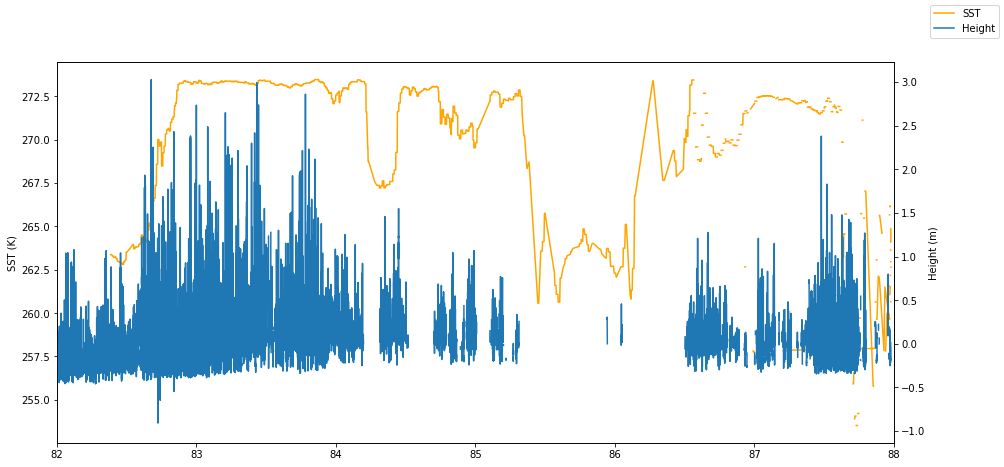

In [32]:
is2_ds = is2_ds.set_coords(['latitude'])

fig, ax1 = plt.subplots(figsize=(15, 7))
ax1.set_xlim(82.,88.)
ax1.plot(is2_ds.latitude, is2_ds.sea_surface_temperature, 
         color='orange', label='SST', zorder=3)
ax1.set_ylabel('SST (K)')

ax2 = ax1.twinx()
ax2.plot(is2_ds.latitude, is2_ds.height_segment_height, label='Height')
ax2.set_ylabel('Height (m)')

fig.legend()